In [1]:
import numpy as np
import pandas as pd
import os
from sklearn.metrics import classification_report
import seaborn as sn; sn.set(font_scale = 1.4)
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tqdm import tqdm

In [2]:
class_names = ['mountain', 'street', 'glacier', 'buildings', 'sea', 'forest']
class_names_label = {class_name: i for i, class_name in enumerate(class_names)}  # just enumerates each class name

nb_classes = len(class_names)

print(class_names_label)

IMAGE_SIZE = (150, 150)  # resize when using a neural net

{'mountain': 0, 'street': 1, 'glacier': 2, 'buildings': 3, 'sea': 4, 'forest': 5}


In [3]:
# load data from pc.  without deposit to main.

def load_data():
    # C:\Users\mkroh\Desktop\Fun stuff\IntelImageClassification
    DIRECTORY = r"C:\Users\mkroh\Desktop\Fun stuff\IntelImageClassification"
    CATEGORY = ["seg_train", "seg_test"]
    
    output = []
    
    for category in CATEGORY:
        path = os.path.join(DIRECTORY, category)
        print(path)
        images = []
        labels = []
        
        print("Loading {}".format(category))
        
        for folder in os.listdir(path):
            label = class_names_label[folder]
            
            for file in os.listdir(os.path.join(path, folder)):
                img_path = os.path.join(os.path.join(path, folder), file)
                
                image = cv2.imread(img_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # cv2 artifact
                image = cv2.resize(image, IMAGE_SIZE)
                
                images.append(image)
                labels.append(label)
                
        images = np.array(images, dtype = 'float32')
        labels = np.array(labels, dtype = 'int32')
        
        output.append((images, labels))
        
    return output

In [4]:
(train_images, train_labels), (test_images, test_labels) = load_data()

C:\Users\mkroh\Desktop\Fun stuff\IntelImageClassification\seg_train
Loading seg_train
C:\Users\mkroh\Desktop\Fun stuff\IntelImageClassification\seg_test
Loading seg_test


In [5]:
train_images, train_labels = shuffle(train_images, train_labels, random_state = 25)

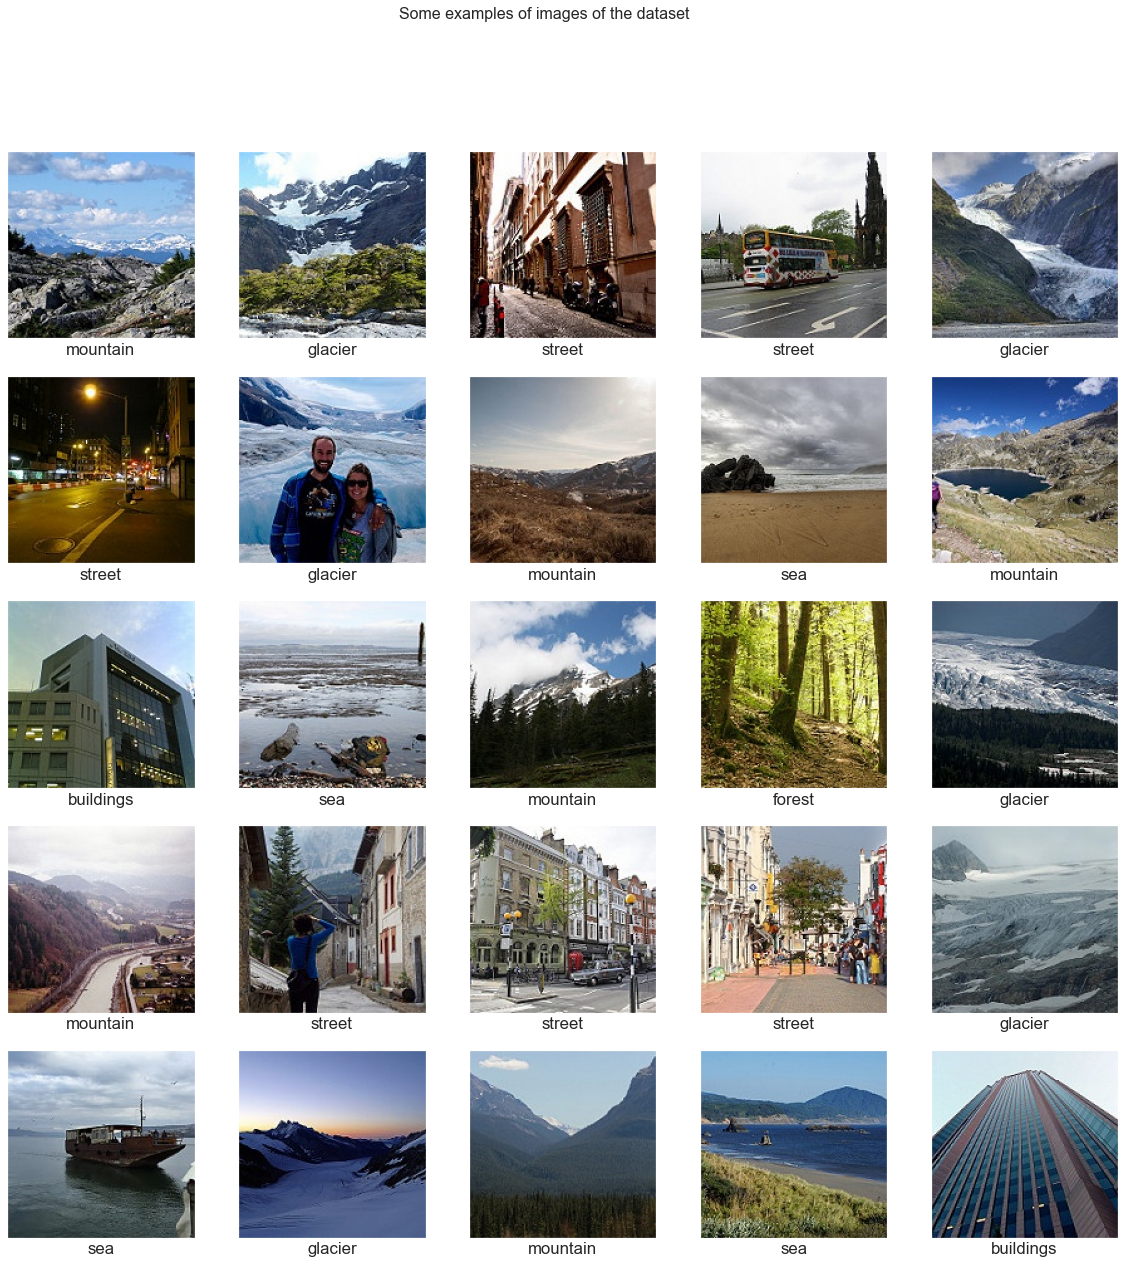

In [6]:
def display_examples(class_names, images, labels):
    figsize = (20,20)
    fig = plt.figure(figsize=figsize)
    fig.suptitle("Some examples of images of the dataset", fontsize = 16)
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i].astype(np.uint8))  # needs uint8 instead of float to work with pyplot
        plt.xlabel(class_names[labels[i]])
    plt.show()
    
display_examples(class_names, train_images, train_labels)    

In [7]:
# Conv2D: 2D - image, 3D - video, 1D could be time
# Input shape = 150 x 150, 3 colors

# Activation default is relu, non linearity
# 32 = how many conv nn are being spun up
# 3x3 is the image walker/window
# Dense layers, relu (non linearity, euclidean geometry) and softmax (activated or not, is not zero but just a tad less)
## tangent activation -1 to 1

# 2 pools, each with its own maxpool beneath, added two more pools to try to improve things.

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation = 'relu', input_shape = (150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation = tf.nn.relu),
    tf.keras.layers.Dense(6, activation = tf.nn.softmax)    
])

In [8]:
# adam fits better on bigger data.
# maximize the loss of error

model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

In [9]:
# run the fit
# batch size: how many images sending through at a time

history = model.fit(train_images, train_labels, batch_size = 128, epochs = 4, validation_split = 0.25)

Epoch 1/4
83/83 [==============================] - 153s 2s/step - loss: 4.0059 - accuracy: 0.3571 - val_loss: 1.2390 - val_accuracy: 0.5124
Epoch 2/4
83/83 [==============================] - 162s 2s/step - loss: 1.0345 - accuracy: 0.5937 - val_loss: 1.0165 - val_accuracy: 0.6070
Epoch 3/4
83/83 [==============================] - 151s 2s/step - loss: 0.8871 - accuracy: 0.6618 - val_loss: 0.8719 - val_accuracy: 0.6671
Epoch 4/4
83/83 [==============================] - 155s 2s/step - loss: 0.8053 - accuracy: 0.7034 - val_loss: 0.9305 - val_accuracy: 0.6472


In [10]:
def plot_accuracy_loss(history):
    fig = plt.figure(figsize = (10,5))
    
    plt.subplot(221)
    plt.plot(history.history['accuracy'], 'bo--', label = 'acc')
    plt.plot(history.history['val_accuracy'], 'ro--', label = 'val_acc')
    plt.title("train_acc vs val_acc")
    plt.ylabel("accuracy")
    plt.xlabel("epochs")
    plt.legend()
    
    plt.subplot(222)
    plt.plot(history.history['loss'], 'bo--', label = "loss")
    plt.plot(history.history['val_loss'], 'ro--', label = "val_loss")
    plt.title("train_loss vs val_loss")
    plt.ylabel("loss")
    plt.xlabel("epochs")
    
    plt.legend()
    plt.show()

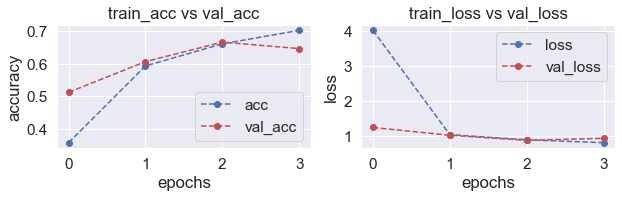

In [11]:
plot_accuracy_loss(history)

#### The left plot shows that the crossover point is two epochs - this means that there really isn't much point of running it after that point, and that the improved accuracy thereafter is due to overfitting.

#### To try to improve things just a bit, I added two layers to the model and the difference is noticeable.  The before:

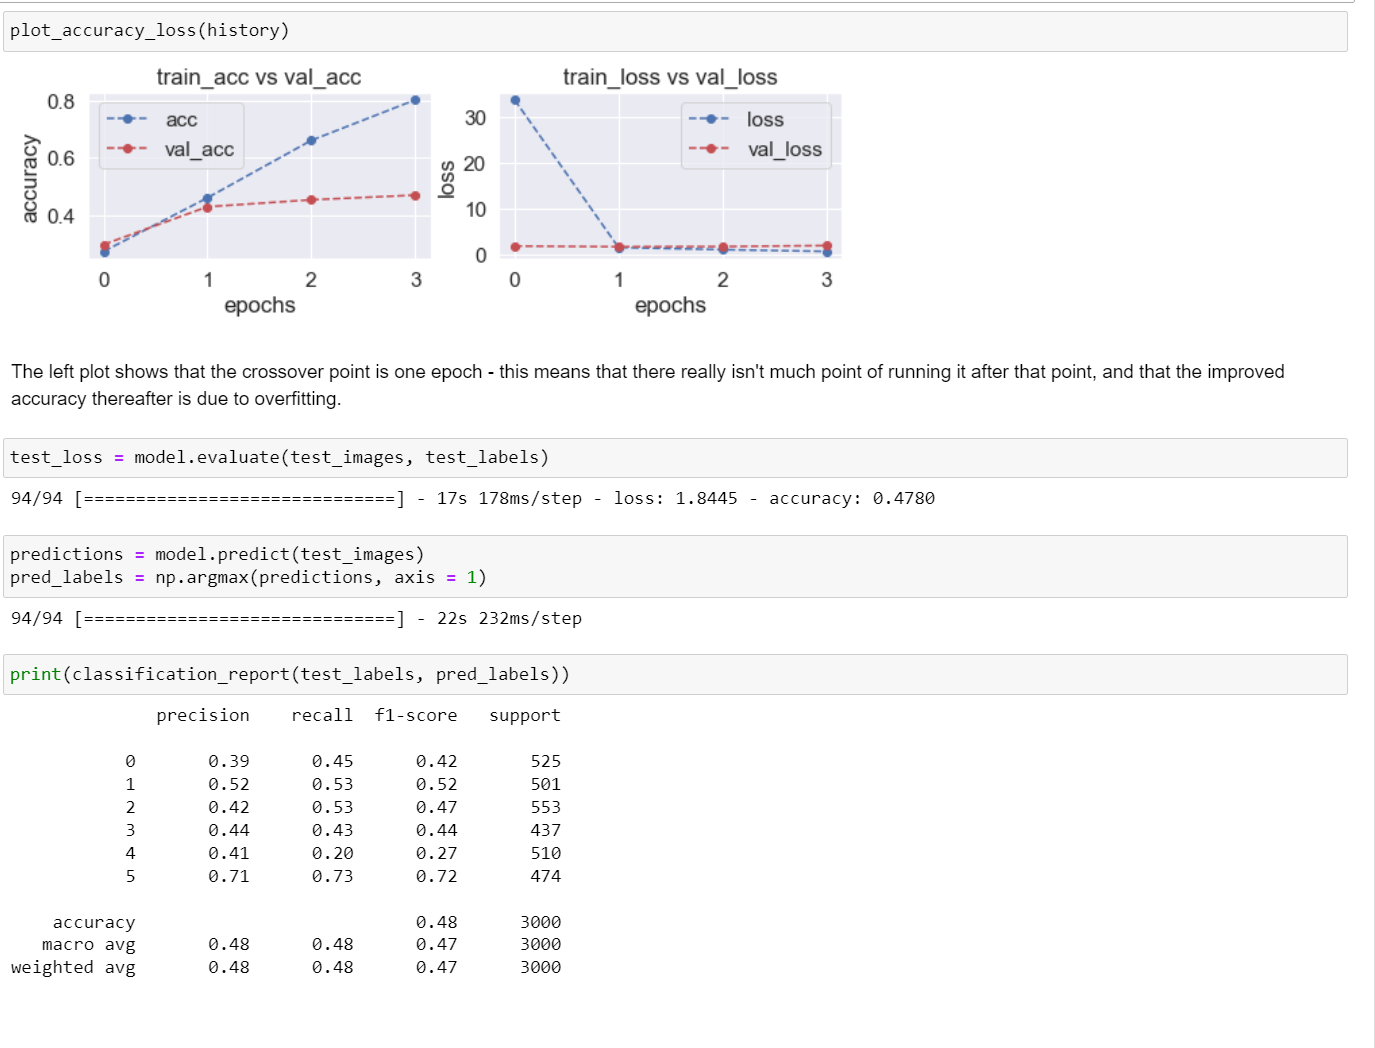

In [12]:
test_loss = model.evaluate(test_images, test_labels)

94/94 [==============================] - 7s 76ms/step - loss: 0.9471 - accuracy: 0.6320


In [13]:
predictions = model.predict(test_images)
pred_labels = np.argmax(predictions, axis = 1)

94/94 [==============================] - 7s 74ms/step


In [14]:
print(classification_report(test_labels, pred_labels))

              precision    recall  f1-score   support

           0       0.55      0.76      0.64       525
           1       0.64      0.76      0.69       501
           2       0.77      0.47      0.58       553
           3       0.48      0.68      0.57       437
           4       0.64      0.28      0.39       510
           5       0.82      0.88      0.85       474

    accuracy                           0.63      3000
   macro avg       0.65      0.64      0.62      3000
weighted avg       0.65      0.63      0.62      3000



#### Now here is a big difference.  The macro avg in the original case was 0.45 (shown a few steps higher).  Two additional layers moved the macro average to 0.68, which is great.  I am still overfitting and would want to adjust for that if I continued.

#### The other thing to note is that the scores generally improved across the board.  We would somewhat expect this but it's nice to see the additional improvements affecting the data somewhat uniformly.

#### Now I'll try to rotate the test_images

In [15]:
# consider rotation
for image in train_images:
    tf.keras.preprocessing.image.random_rotation(image, rg=45, fill_mode = 'nearest', interpolation_order = 1)

#### consider adding rotated images?

In [16]:
# re-run the fit

history = model.fit(train_images, train_labels, batch_size = 128, epochs = 4, validation_split = 0.2)

Epoch 1/4
88/88 [==============================] - 137s 2s/step - loss: 0.7139 - accuracy: 0.7359 - val_loss: 0.8096 - val_accuracy: 0.7004
Epoch 2/4
88/88 [==============================] - 164s 2s/step - loss: 0.6362 - accuracy: 0.7646 - val_loss: 0.7718 - val_accuracy: 0.7154
Epoch 3/4
88/88 [==============================] - 119s 1s/step - loss: 0.5269 - accuracy: 0.8105 - val_loss: 0.7874 - val_accuracy: 0.7325
Epoch 4/4
88/88 [==============================] - 131s 1s/step - loss: 0.4518 - accuracy: 0.8400 - val_loss: 0.7669 - val_accuracy: 0.7253


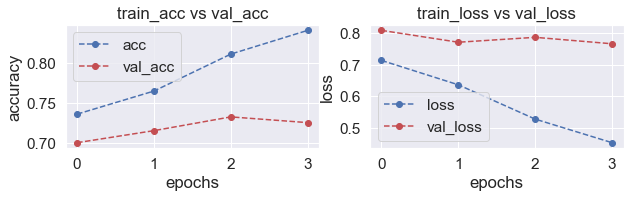

In [17]:
# re-plot with updated history

plot_accuracy_loss(history)

#### Marked differences can now be see with the two additional layers.  The before:

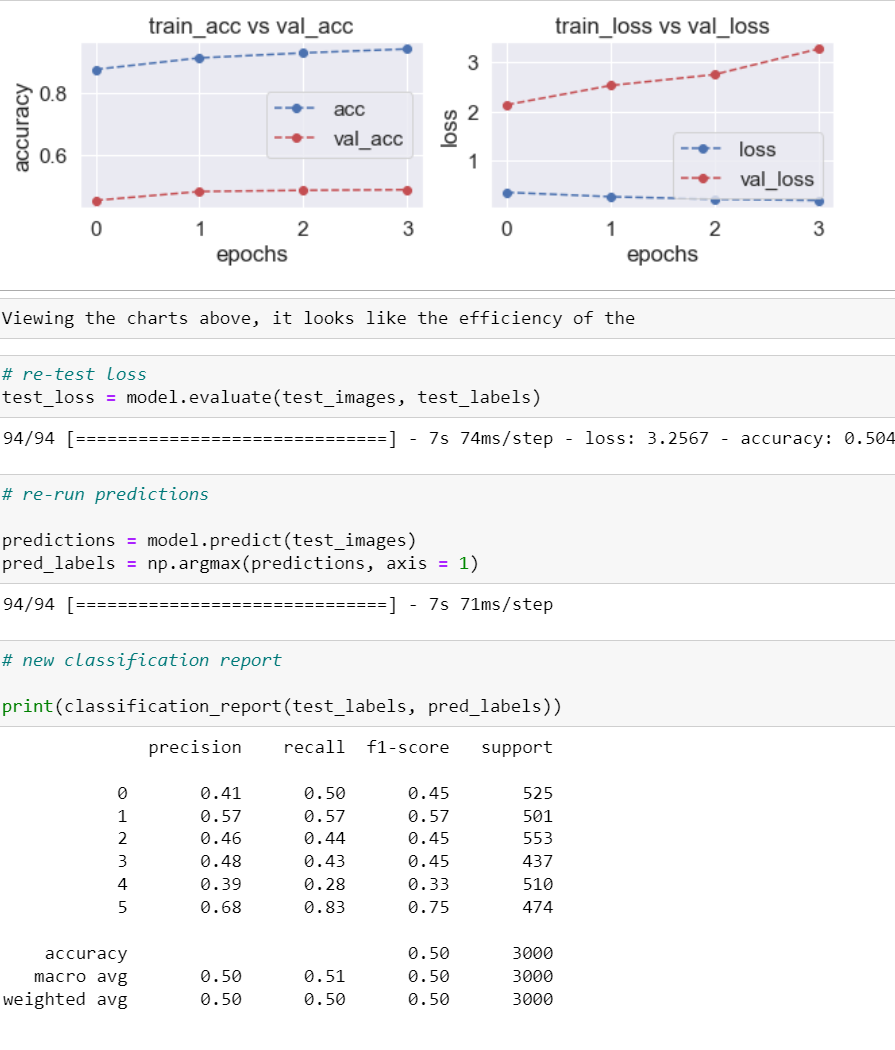

#### We have some degree of intersectionality at the start of the model, where we didn't before.  We also see other differences, particularly with loss in terms of scale and shape of curve across the epochs.  I'd like to dig deeper into validation accuracy and why the curve does not intersect with accuracy, but interesting enough for now.

In [18]:
# re-test loss
test_loss = model.evaluate(test_images, test_labels)

94/94 [==============================] - 7s 74ms/step - loss: 0.7485 - accuracy: 0.7400


In [19]:
# re-run predictions

predictions = model.predict(test_images)
pred_labels = np.argmax(predictions, axis = 1)

94/94 [==============================] - 7s 74ms/step


In [20]:
# new classification report

print(classification_report(test_labels, pred_labels))

              precision    recall  f1-score   support

           0       0.63      0.85      0.72       525
           1       0.83      0.62      0.71       501
           2       0.78      0.66      0.71       553
           3       0.70      0.70      0.70       437
           4       0.73      0.68      0.70       510
           5       0.82      0.95      0.88       474

    accuracy                           0.74      3000
   macro avg       0.75      0.74      0.74      3000
weighted avg       0.75      0.74      0.74      3000



#### As seen above, there is a huge difference with adding the additional two layers to the model.  Improvements all around.  Champagne for all!

#### Definitely need to explore the validation aspects and I'd like to find a way to view the rotated images.  In this case I really want to understand how the rotated images helped improve things so much.  I know that there is quite a bit of "sky" in the images, and I want to understand the edge effects as the rotation approaches 45 degrees.  

#### Retaining the additional layers, just changing the box scansize to see what happens

In [21]:
# change scansize

modelscansizechange = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (5,5), activation = 'relu', input_shape = (150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (5,5), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (5,5), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (5,5), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation = tf.nn.relu),
    tf.keras.layers.Dense(6, activation = tf.nn.softmax)    
])

In [22]:
# new compile

modelscansizechange.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

In [23]:
# re-fit

history = modelscansizechange.fit(train_images, train_labels, batch_size = 128, epochs = 4, validation_split = 0.25)

Epoch 1/4
83/83 [==============================] - 200s 2s/step - loss: 3.7689 - accuracy: 0.2919 - val_loss: 1.4594 - val_accuracy: 0.4203
Epoch 2/4
83/83 [==============================] - 218s 3s/step - loss: 1.2342 - accuracy: 0.5012 - val_loss: 1.0989 - val_accuracy: 0.5292
Epoch 3/4
83/83 [==============================] - 218s 3s/step - loss: 0.9999 - accuracy: 0.5865 - val_loss: 1.0059 - val_accuracy: 0.5876
Epoch 4/4
83/83 [==============================] - 217s 3s/step - loss: 0.9282 - accuracy: 0.6258 - val_loss: 0.9499 - val_accuracy: 0.6070


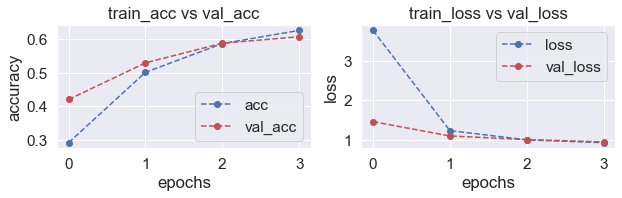

In [24]:
# call plotting function.  should probably change history to another name

plot_accuracy_loss(history)

In [25]:
# re-test loss
test_loss = modelscansizechange.evaluate(test_images, test_labels)

94/94 [==============================] - 11s 115ms/step - loss: 0.9415 - accuracy: 0.6127


In [26]:
# re-run predictions

predictions = modelscansizechange.predict(test_images)
pred_labels = np.argmax(predictions, axis = 1)

94/94 [==============================] - 11s 114ms/step


In [27]:
# classy report

print(classification_report(test_labels, pred_labels))

              precision    recall  f1-score   support

           0       0.48      0.74      0.59       525
           1       0.71      0.60      0.65       501
           2       0.58      0.64      0.61       553
           3       0.59      0.64      0.61       437
           4       0.52      0.22      0.31       510
           5       0.86      0.84      0.85       474

    accuracy                           0.61      3000
   macro avg       0.62      0.61      0.60      3000
weighted avg       0.62      0.61      0.60      3000



#### Very cool.  Changing the scanning window definitely has a impact on things.  In this case, negatively, lol.

## Now for the VGG16 Model

In [22]:
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from keras.models import Model

In [23]:
# import the VGG16 model.  initialize and add input and output layers

model = VGG16(weights = 'imagenet', include_top = False)
model = Model(inputs = model.inputs, outputs = model.layers[-5].output)

In [24]:
# extract features and save as train and test

train_features = model.predict(train_images)
test_features = model.predict(test_images)

94/94 [==============================] - 258s 3s/step


In [25]:
from keras.layers import Input, Dense, Conv2D, Activation, MaxPooling2D, Flatten

In [27]:
model2 = VGG16(weights = 'imagenet', include_top = False)

input_shape = model2.layers[-4].get_input_shape_at(0)
layer_input = Input(shape = (9,9,512))

x = layer_input
for layer in model2.layers[-4::1]:
    x = layer(x)
    
x = Conv2D(64, (3,3), activation = 'relu')(x)
x = MaxPooling2D(pool_size = (2,2))(x)
x = Flatten()(x)
x = Dense(100, activation = 'relu')(x)
x = Dense(6, activation = 'softmax')(x)

In [28]:
# new model

new_model = Model(layer_input, x)

In [29]:
new_model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

In [30]:
history = new_model.fit(train_features, train_labels, batch_size = 128, epochs = 10, validation_split = 0.2)

Epoch 1/10
88/88 [==============================] - 314s 4s/step - loss: 2.8359 - accuracy: 0.1742 - val_loss: 1.7911 - val_accuracy: 0.1756
Epoch 2/10
88/88 [==============================] - 320s 4s/step - loss: 1.7910 - accuracy: 0.1798 - val_loss: 1.7909 - val_accuracy: 0.1756
Epoch 3/10
88/88 [==============================] - 317s 4s/step - loss: 1.7909 - accuracy: 0.1798 - val_loss: 1.7909 - val_accuracy: 0.1756
Epoch 4/10
88/88 [==============================] - 314s 4s/step - loss: 1.7909 - accuracy: 0.1798 - val_loss: 1.7909 - val_accuracy: 0.1756
Epoch 5/10
88/88 [==============================] - 300s 3s/step - loss: 1.7909 - accuracy: 0.1798 - val_loss: 1.7908 - val_accuracy: 0.1756
Epoch 6/10
88/88 [==============================] - 300s 3s/step - loss: 1.7909 - accuracy: 0.1798 - val_loss: 1.7908 - val_accuracy: 0.1756
Epoch 7/10
88/88 [==============================] - 299s 3s/step - loss: 1.7909 - accuracy: 0.1798 - val_loss: 1.7908 - val_accuracy: 0.1756
Epoch 8/10
88

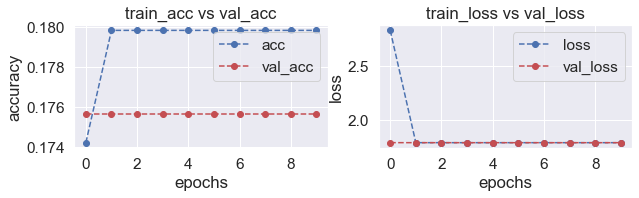

In [31]:
plot_accuracy_loss(history)

Similar to results above, the crossover point is (below) one epoch.  Further investigation required!

This was more an exercise in applying the VGG16 model and all of it's fun bits.